In [10]:
import pandas as pd
from io import StringIO

def parse_html_file(file_path):
    """
    Read an HTML file and parse its table content into a pandas DataFrame
    
    Parameters:
    file_path (str): Path to the HTML file
    
    Returns:
    pandas.DataFrame: Parsed table data
    """
    # Read the HTML file
    with open(file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()
    
    # Read HTML content using pandas
    df = pd.read_html(StringIO(html_content))[0]
    
    # Clean up column names
    df.columns = df.columns.str.strip()
    
    # Replace empty strings with NaN
    df = df.replace(r'^\s*$', pd.NA, regex=True)
    
    # Convert wage column to numeric, removing '£' and 'p/w'
    if 'Wage' in df.columns:
        df['Wage'] = df['Wage'].str.replace('£', '').str.replace(' p/w', '').str.replace(',', '')
        df['Wage'] = pd.to_numeric(df['Wage'], errors='coerce')
    
    # Convert numeric columns to appropriate types
    numeric_columns = ['Age', 'Com', 'Ecc', 'Pun', '1v1', 'Acc', 'Aer', 'Agg', 'Agi', 'Ant', 
                      'Bal', 'Bra', 'Cmd', 'Cnt', 'Cmp', 'Cro', 'Dec', 'Det', 'Dri', 'Fin',
                      'Fir', 'Fla', 'Han', 'Hea', 'Jum', 'Kic', 'Ldr', 'Lon', 'Mar', 'OtB',
                      'Pac', 'Pas', 'Pos', 'Ref', 'Sta', 'Str', 'Tck', 'Tea', 'Tec', 'Thr',
                      'TRO', 'Vis', 'Wor', 'Cor', 'Fre', 'L Th', 'Pen']
    
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

df = parse_html_file("wage_player_export.html")
df = df.drop(columns=["Inf"])

In [11]:
print(df[df['Name'] == "David Raya"])
print(df.columns)

           Name Position  Nat  Age     Club    Wage       Personality  \
233  David Raya       GK  ESP   28  Arsenal  110000  Fairly Ambitious   

      Left Foot   Right Foot  Com  ...  Wor  Cor  Fre  L Th  Pen  Nat.1  \
233  Reasonable  Very Strong   14  ...   13    6   10     3    3     16   

     Height                  Division  Injury Risk    Expires  
233    6'0"  English Premier Division    Increased  30/6/2027  

[1 rows x 60 columns]
Index(['Name', 'Position', 'Nat', 'Age', 'Club', 'Wage', 'Personality',
       'Left Foot', 'Right Foot', 'Com', 'Ecc', 'Pun', '1v1', 'Acc', 'Aer',
       'Agg', 'Agi', 'Ant', 'Bal', 'Bra', 'Cmd', 'Cnt', 'Cmp', 'Cro', 'Dec',
       'Det', 'Dri', 'Fin', 'Fir', 'Fla', 'Han', 'Hea', 'Jum', 'Kic', 'Ldr',
       'Lon', 'Mar', 'OtB', 'Pac', 'Pas', 'Pos', 'Ref', 'Sta', 'Str', 'Tck',
       'Tea', 'Tec', 'Thr', 'TRO', 'Vis', 'Wor', 'Cor', 'Fre', 'L Th', 'Pen',
       'Nat.1', 'Height', 'Division', 'Injury Risk', 'Expires'],
      dtype='object')


In [13]:
def process_football_data(df):
    """
    Process football player data with position, contract, and physical features.
    Handles missing values and invalid dates in the contract expiry field.
    """
    # Positional features
    position_features = {
        "is_gk": r"GK",
        "is_cb": r"D \((C|LC|RC|RLC)\)",
        "is_fb": r"D \([LR]+[C]?\)|WB",
        "is_dm": r"DM",
        "is_cm": r"M \([LR]*C[LR]*\)",
        "is_w": r"(M|AM|M/AM) \([LR]+\)",
        "is_am": r"AM \([LR]*C[LR]*\)",
        "is_st": r"ST"
    }
    
    for feature, pattern in position_features.items():
        df[feature] = df["Position"].str.contains(pattern, regex=True).astype(int)
    
    # Calculate number of positions
    position_cols = ["is_cb", "is_fb", "is_dm", "is_cm", "is_w", "is_am", "is_st"]
    df["num_pos"] = df[position_cols].sum(axis=1)
    
    # Foot features
    strong_feet = ["Strong", "Fairly Strong", "Very Strong"]
    df["strong_left"] = df["Left Foot"].isin(strong_feet).astype(int)
    df["strong_right"] = df["Right Foot"].isin(strong_feet).astype(int)
    
    # Contract feature with proper handling of invalid dates
    reference_date = pd.to_datetime("2023-07-01")
    
    def process_expiry_date(date_str):
        if pd.isna(date_str) or date_str == "-":
            return pd.NaT
        try:
            return pd.to_datetime(date_str)
        except:
            return pd.NaT
    
    df["Expires"] = df["Expires"].apply(process_expiry_date)
    df["days_until_expiry"] = (df["Expires"] - reference_date).dt.days
    
    # Height feature
    def height_to_cm(height):
        try:
            feet, inches = map(int, height.replace('"', '').split("'"))
            return (feet * 30.48) + (inches * 2.54)
        except:
            return np.nan
    
    df["height_cm"] = df["Height"].apply(height_to_cm)
    
    # Remove goalkeepers
    df = df[~df["Position"].str.contains("GK", na=False)]
    
    return df

df = process_football_data(df)

C:\Users\Owner\AppData\Local\Temp\ipykernel_8964\1356896123.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[feature] = df["Position"].str.contains(pattern, regex=True).astype(int)
C:\Users\Owner\AppData\Local\Temp\ipykernel_8964\1356896123.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[feature] = df["Position"].str.contains(pattern, regex=True).astype(int)
C:\Users\Owner\AppData\Local\Temp\ipykernel_8964\1356896123.py:37: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(date_str)


In [14]:
reg_cols = [["Wage", "is_cb", "is_fb", "is_dm", "is_cm", "is_w", "is_am", "is_st", "num_pos", "Age",
              "strong_left", "strong_right", "days_until_expiry", "height_cm", "Club", "Division", "Nat", 'Com', 'Ecc', 'Pun', '1v1', 'Acc', 'Aer',
       'Agg', 'Agi', 'Ant', 'Bal', 'Bra', 'Cmd', 'Cnt', 'Cmp', 'Cro', 'Dec',
       'Det', 'Dri', 'Fin', 'Fir', 'Fla', 'Han', 'Hea', 'Jum', 'Kic', 'Ldr',
       'Lon', 'Mar', 'OtB', 'Pac', 'Pas', 'Pos', 'Ref', 'Sta', 'Str', 'Tck',
       'Tea', 'Tec', 'Thr', 'TRO', 'Vis', 'Wor', 'Cor', 'Fre', 'L Th', 'Pen']]

reg_df = pd.DataFrame()



reg_df = df[~df['Position'].str.contains('GK', na=False)][reg_cols[0]].copy() # remove goalkeepers

reg_df = pd.get_dummies(reg_df, columns=['Nat', 'Club', 'Division'])


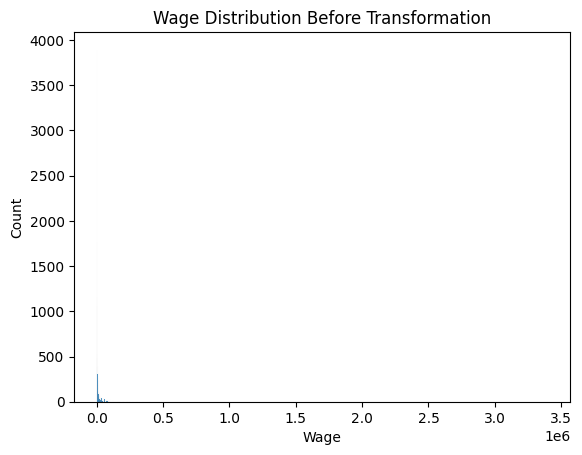

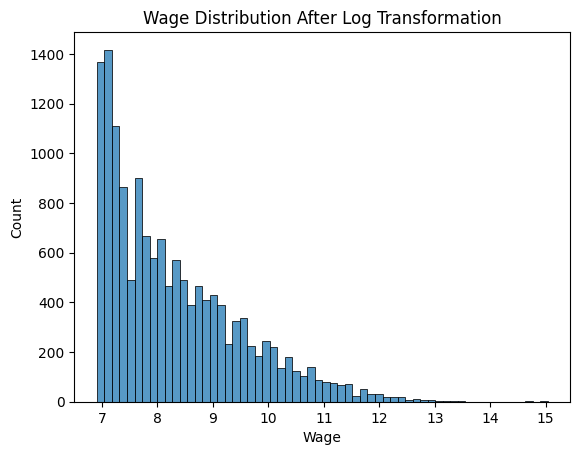

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Before transformation
sns.histplot(df['Wage'])
plt.title('Wage Distribution Before Transformation')
plt.show()

# After transformation
sns.histplot(np.log1p(df['Wage']))
plt.title('Wage Distribution After Log Transformation')
plt.show()

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
import xgboost as xgb
import numpy as np
import pandas as pd

# Prepare data
X = reg_df.drop('Wage', axis=1)  # Features
y = np.log1p(reg_df['Wage'])     # Log-transformed target

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# Initialize model with the optimized parameters
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.02,    
    max_depth=3,           
    subsample=0.7,         
    colsample_bytree=0.7,  
    min_child_weight=4,    
    gamma=1,               
    reg_alpha=0.1,         
    reg_lambda=1,          
    random_state=42    
)

# Simple fit without early stopping
model.fit(
    X_train, 
    y_train,
    verbose=False
)

# Get predictions for both train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Transform predictions back to original scale
y_train_original = np.expm1(y_train)
y_train_pred_original = np.expm1(y_train_pred)
y_test_original = np.expm1(y_test)
y_test_pred_original = np.expm1(y_test_pred)

print("Model Performance and Overfitting Analysis:")
print("-" * 50)

# Log scale metrics
print("Log Scale Metrics:")
train_r2_log = r2_score(y_train, y_train_pred)
test_r2_log = r2_score(y_test, y_test_pred)
train_rmse_log = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse_log = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training R²: {train_r2_log:.3f}")
print(f"Test R²: {test_r2_log:.3f}")
print(f"R² Difference: {train_r2_log - test_r2_log:.3f}")
print(f"\nTraining RMSE: {train_rmse_log:.3f}")
print(f"Test RMSE: {test_rmse_log:.3f}")
print(f"RMSE Difference: {test_rmse_log - train_rmse_log:.3f}")

# Original scale metrics
print("\nOriginal Scale Metrics:")
train_mape = mean_absolute_percentage_error(y_train_original, y_train_pred_original)
test_mape = mean_absolute_percentage_error(y_test_original, y_test_pred_original)
train_mae = mean_absolute_error(y_train_original, y_train_pred_original)
test_mae = mean_absolute_error(y_test_original, y_test_pred_original)

print(f"Training MAPE: {train_mape:.1%}")
print(f"Test MAPE: {test_mape:.1%}")
print(f"MAPE Difference: {test_mape - train_mape:.1%}")
print(f"\nTraining MAE: £{train_mae:,.2f}")
print(f"Test MAE: £{test_mae:,.2f}")
print(f"MAE Difference: £{test_mae - train_mae:,.2f}")

# Error distributions
train_errors = abs(y_train_original - y_train_pred_original)
test_errors = abs(y_test_original - y_test_pred_original)

print('\nError Distribution (Original Scale):')
print("Training Errors:")
print(f'25th percentile: £{np.percentile(train_errors, 25):,.2f}')
print(f'Median error: £{np.percentile(train_errors, 50):,.2f}')
print(f'75th percentile: £{np.percentile(train_errors, 75):,.2f}')
print("\nTest Errors:")
print(f'25th percentile: £{np.percentile(test_errors, 25):,.2f}')
print(f'Median error: £{np.percentile(test_errors, 50):,.2f}')
print(f'75th percentile: £{np.percentile(test_errors, 75):,.2f}')

# Percentage error distributions
train_percent_errors = abs((y_train_original - y_train_pred_original) / y_train_original * 100)
test_percent_errors = abs((y_test_original - y_test_pred_original) / y_test_original * 100)

print('\nPercentage Error Distribution:')
print("Training Errors:")
print(f'25th percentile: {np.percentile(train_percent_errors, 25):.1f}%')
print(f'Median error: {np.percentile(train_percent_errors, 50):.1f}%')
print(f'75th percentile: {np.percentile(train_percent_errors, 75):.1f}%')
print("\nTest Errors:")
print(f'25th percentile: {np.percentile(test_percent_errors, 25):.1f}%')
print(f'Median error: {np.percentile(test_percent_errors, 50):.1f}%')
print(f'75th percentile: {np.percentile(test_percent_errors, 75):.1f}%')

# Feature importance
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
})
print("\nTop 10 Most Important Features:")
print(importance_df.sort_values('importance', ascending=False).head(10))

# Cross-validation
cv_scores = cross_val_score(
    model, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='r2'
)
print(f"\nCross-validation Results:")
print(f"R² scores: {cv_scores}")
print(f"Mean R²: {cv_scores.mean():.3f}")
print(f"Std R²: {cv_scores.std():.3f}")

# Error by wage brackets
train_brackets = pd.qcut(y_train_original, q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
test_brackets = pd.qcut(y_test_original, q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

train_error_by_bracket = pd.DataFrame({
    'Actual': y_train_original,
    'Predicted': y_train_pred_original,
    'Bracket': train_brackets
})
test_error_by_bracket = pd.DataFrame({
    'Actual': y_test_original,
    'Predicted': y_test_pred_original,
    'Bracket': test_brackets
})

train_error_by_bracket['Percentage_Error'] = abs(train_error_by_bracket['Predicted'] - train_error_by_bracket['Actual']) / train_error_by_bracket['Actual'] * 100
test_error_by_bracket['Percentage_Error'] = abs(test_error_by_bracket['Predicted'] - test_error_by_bracket['Actual']) / test_error_by_bracket['Actual'] * 100

print("\nMAPE by Wage Bracket:")
print("Training:")
print(train_error_by_bracket.groupby('Bracket')['Percentage_Error'].mean().round(1))
print("\nTest:")
print(test_error_by_bracket.groupby('Bracket')['Percentage_Error'].mean().round(1))

Model Performance and Overfitting Analysis:
--------------------------------------------------
Log Scale Metrics:
Training R²: 0.788
Test R²: 0.764
R² Difference: 0.024

Training RMSE: 0.552
Test RMSE: 0.594
RMSE Difference: 0.042

Original Scale Metrics:
Training MAPE: 46.6%
Test MAPE: 50.0%
MAPE Difference: 3.4%

Training MAE: £5,172.41
Test MAE: £5,600.81
MAE Difference: £428.40

Error Distribution (Original Scale):
Training Errors:
25th percentile: £420.40
Median error: £1,050.83
75th percentile: £3,114.57

Test Errors:
25th percentile: £428.89
Median error: £1,162.82
75th percentile: £3,511.51

Percentage Error Distribution:
Training Errors:
25th percentile: 16.3%
Median error: 34.8%
75th percentile: 58.9%

Test Errors:
25th percentile: 16.6%
Median error: 37.0%
75th percentile: 61.8%

Top 10 Most Important Features:
                                feature  importance
21                                  Ant    0.056558
2157  Division_English Premier Division    0.047058
26        

C:\Users\Owner\AppData\Local\Temp\ipykernel_8964\785163068.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(train_error_by_bracket.groupby('Bracket')['Percentage_Error'].mean().round(1))
C:\Users\Owner\AppData\Local\Temp\ipykernel_8964\785163068.py:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(test_error_by_bracket.groupby('Bracket')['Percentage_Error'].mean().round(1))


In [ ]:

player = 'Antony'
player_data = df[df['Name'] == player ]

if len(player_data) == 0:
    print("Player not found in dataset")
else:
    # Create a single row dataframe with exactly the same features as X (training data)
    player_features = pd.DataFrame(columns=X.columns)
    player_features.loc[0] = 0  # Initialize with zeros
    
    # Fill in the numerical/boolean columns
    numeric_cols = ['is_cb', 'is_fb', 'is_dm', 'is_cm', 'is_w', 'is_am', 'is_st', 
                   'num_pos', 'Age', 'strong_left', 'strong_right', 'days_until_expiry', 
                   'height_cm', 'Com', 'Ecc', 'Pun', '1v1', 'Acc', 'Aer', 'Agg', 'Agi', 
                   'Ant', 'Bal', 'Bra', 'Cmd', 'Cnt', 'Cmp', 'Cro', 'Dec', 'Det', 'Dri', 
                   'Fin', 'Fir', 'Fla', 'Han', 'Hea', 'Jum', 'Kic', 'Ldr', 'Lon', 'Mar', 
                   'OtB', 'Pac', 'Pas', 'Pos', 'Ref', 'Sta', 'Str', 'Tck', 'Tea', 'Tec', 
                   'Thr', 'TRO', 'Vis', 'Wor', 'Cor', 'Fre', 'L Th', 'Pen']
    
    for col in numeric_cols:
        if col in player_data.columns and col in player_features.columns:
            player_features[col] = player_data[col].values[0]
    
    # Handle categorical columns (one-hot encoded)
    # Nationality
    nat_col = f"Nat_{player_data['Nat'].values[0]}"
    if nat_col in player_features.columns:
        player_features[nat_col] = 1
    
    # Club
    club_col = f"Club_{player_data['Club'].values[0]}"
    if club_col in player_features.columns:
        player_features[club_col] = 1
    
    # Division
    div_col = f"Division_{player_data['Division'].values[0]}"
    if div_col in player_features.columns:
        player_features[div_col] = 1
    
    # Make prediction
    pred_log = model.predict(player_features)
    predicted_wage = np.expm1(pred_log[0])
    actual_wage = player_data['Wage'].values[0]
    
    print(f"\nPrediction Results for {player}:")
    print("-" * 50)
    print(f"Predicted Wage: £{predicted_wage:,.2f} per week")
    print(f"Actual Wage: £{actual_wage:,.2f} per week")
    print(f"Prediction Error: £{abs(predicted_wage - actual_wage):,.2f}")
    print(f"Percentage Error: {abs(predicted_wage - actual_wage) / actual_wage * 100:.1f}%")
    
    # Show top contributing features
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_,
        'value': player_features.iloc[0].values
    })
    
    # Calculate contribution (importance * actual value)
    feature_importance['contribution'] = feature_importance['importance'] * abs(feature_importance['value'])
    
    print(f"\nTop 10 Contributing Features to {player}'s Prediction:")
    print(feature_importance.sort_values('contribution', ascending=False).head(10)[['feature', 'value', 'importance', 'contribution']])


Prediction Results for Antony:
--------------------------------------------------
Predicted Wage: £65,713.37 per week
Actual Wage: £150,000.00 per week
Prediction Error: £84,286.63
Percentage Error: 56.2%

Top 10 Contributing Features to Antony's Prediction:
              feature   value  importance  contribution
11  days_until_expiry  1095.0    0.013725     15.028640
21                Ant    12.0    0.056558      0.678698
50                Tec    16.0    0.042410      0.678557
32                Fir    16.0    0.035124      0.561987
26                Cmp    12.0    0.045558      0.546696
22                Bal    14.0    0.037509      0.525130
42                Pac    15.0    0.033918      0.508771
46                Sta    17.0    0.028507      0.484626
49                Tea    14.0    0.024929      0.349011
30                Dri    16.0    0.021395      0.342320


In [36]:
def analyze_wages(df, X, y, model, league_filter=None, club_filter=None, min_wage=0, min_age=0, top_n=5):
    """
    Analyze player wages with optional filtering by league or club
    
    Parameters:
    -----------
    df: DataFrame with player info
    X: Feature matrix
    y: Target wages (log scale)
    model: Trained model
    league_filter: Optional league/division to filter by
    club_filter: Optional club to filter by
    min_wage: Minimum actual wage to consider
    top_n: Number of players to show in each category
    """
    # Get predictions for all players
    y_pred_log = model.predict(X)
    y_pred = np.expm1(y_pred_log)
    y_actual = np.expm1(y)
    
    # Create analysis dataframe
    wage_analysis = pd.DataFrame({
        'Name': df['Name'],
        'Club': df['Club'],
        'Division': df['Division'],
        'Age': df['Age'],
        'Actual_Wage': y_actual,
        'Predicted_Wage': y_pred,
        'Wage_Difference': y_actual - y_pred,
        'Percentage_Difference': ((y_actual - y_pred) / y_pred) * 100
    })
    
    # Apply filters
    if league_filter:
        wage_analysis = wage_analysis[wage_analysis['Division'] == league_filter]
    if club_filter:
        wage_analysis = wage_analysis[wage_analysis['Club'] == club_filter]
    if min_wage > 0:
        wage_analysis = wage_analysis[wage_analysis['Actual_Wage'] >= min_wage]
    if min_wage > 0:
        wage_analysis = wage_analysis[wage_analysis['Age'] >= min_age]
    
    if len(wage_analysis) == 0:
        print("No players found matching the specified filters.")
        return
    
    # Calculate value metrics
    wage_analysis['Overpaid_Amount'] = wage_analysis['Wage_Difference'].apply(lambda x: max(x, 0))
    wage_analysis['Underpaid_Amount'] = wage_analysis['Wage_Difference'].apply(lambda x: min(x, 0))
    
    # Print filter information
    print("\nAnalysis Parameters:")
    print("-" * 50)
    if league_filter:
        print(f"League: {league_filter}")
    if club_filter:
        print(f"Club: {club_filter}")
    if min_wage > 0:
        print(f"Minimum Wage: £{min_wage:,.2f}")
    print(f"Number of players analyzed: {len(wage_analysis)}")
    print()
    
    # Find most overpaid players
    print(f"\nTop {top_n} Most Overpaid Players:")
    print("-" * 50)
    overpaid = wage_analysis.nlargest(top_n, 'Percentage_Difference')
    for _, player in overpaid.iterrows():
        print(f"{player['Name']} ({player['Club']}):")
        print(f"  Age: {player['Age']}")
        print(f"  Actual Wage: £{player['Actual_Wage']:,.2f}")
        print(f"  Predicted Wage: £{player['Predicted_Wage']:,.2f}")
        print(f"  Overpaid by: £{player['Wage_Difference']:,.2f} ({player['Percentage_Difference']:.1f}%)")
        print()
    
    # Find most underpaid players
    print(f"\nTop {top_n} Most Underpaid Players:")
    print("-" * 50)
    underpaid = wage_analysis.nsmallest(top_n, 'Percentage_Difference')
    for _, player in underpaid.iterrows():
        print(f"{player['Name']} ({player['Club']}):")
        print(f"  Age: {player['Age']}")
        print(f"  Actual Wage: £{player['Actual_Wage']:,.2f}")
        print(f"  Predicted Wage: £{player['Predicted_Wage']:,.2f}")
        print(f"  Underpaid by: £{abs(player['Wage_Difference']):,.2f} ({player['Percentage_Difference']:.1f}%)")
        print()
    
    # Summary statistics
    print("\nWage Analysis Summary:")
    print("-" * 50)
    print(f"Average Actual Wage: £{wage_analysis['Actual_Wage'].mean():,.2f}")
    print(f"Average Predicted Wage: £{wage_analysis['Predicted_Wage'].mean():,.2f}")
    print(f"Total Overpaid Amount: £{wage_analysis['Overpaid_Amount'].sum():,.2f}")
    print(f"Total Underpaid Amount: £{abs(wage_analysis['Underpaid_Amount'].sum()):,.2f}")
    print(f"Average Absolute Wage Difference: £{abs(wage_analysis['Wage_Difference']).mean():,.2f}")
    print(f"Median Absolute Wage Difference: £{abs(wage_analysis['Wage_Difference']).median():,.2f}")
    
    return wage_analysis

premier_league_analysis = analyze_wages(
    df, X, y, model, 
    league_filter="English Premier Division",
    min_wage=10000,
    min_age=21,
    #club_filter="Liverpool",
)


Analysis Parameters:
--------------------------------------------------
League: English Premier Division
Minimum Wage: £10,000.00
Number of players analyzed: 396


Top 5 Most Overpaid Players:
--------------------------------------------------
Kalvin Phillips (Ipswich):
  Age: 28
  Actual Wage: £165,000.00
  Predicted Wage: £27,441.38
  Overpaid by: £137,558.62 (501.3%)

Djed Spence (Tottenham):
  Age: 23
  Actual Wage: £45,000.00
  Predicted Wage: £9,205.50
  Overpaid by: £35,794.50 (388.8%)

Odsonne Edouard (Leicester):
  Age: 26
  Actual Wage: £85,000.00
  Predicted Wage: £18,427.34
  Overpaid by: £66,572.66 (361.3%)

James Justin (Leicester):
  Age: 26
  Actual Wage: £65,000.00
  Predicted Wage: £14,262.19
  Overpaid by: £50,737.81 (355.8%)

Jean-Philippe Mateta (Crystal Palace):
  Age: 27
  Actual Wage: £50,000.00
  Predicted Wage: £13,212.43
  Overpaid by: £36,787.57 (278.4%)


Top 5 Most Underpaid Players:
--------------------------------------------------
Jørgen Strand Larsen 

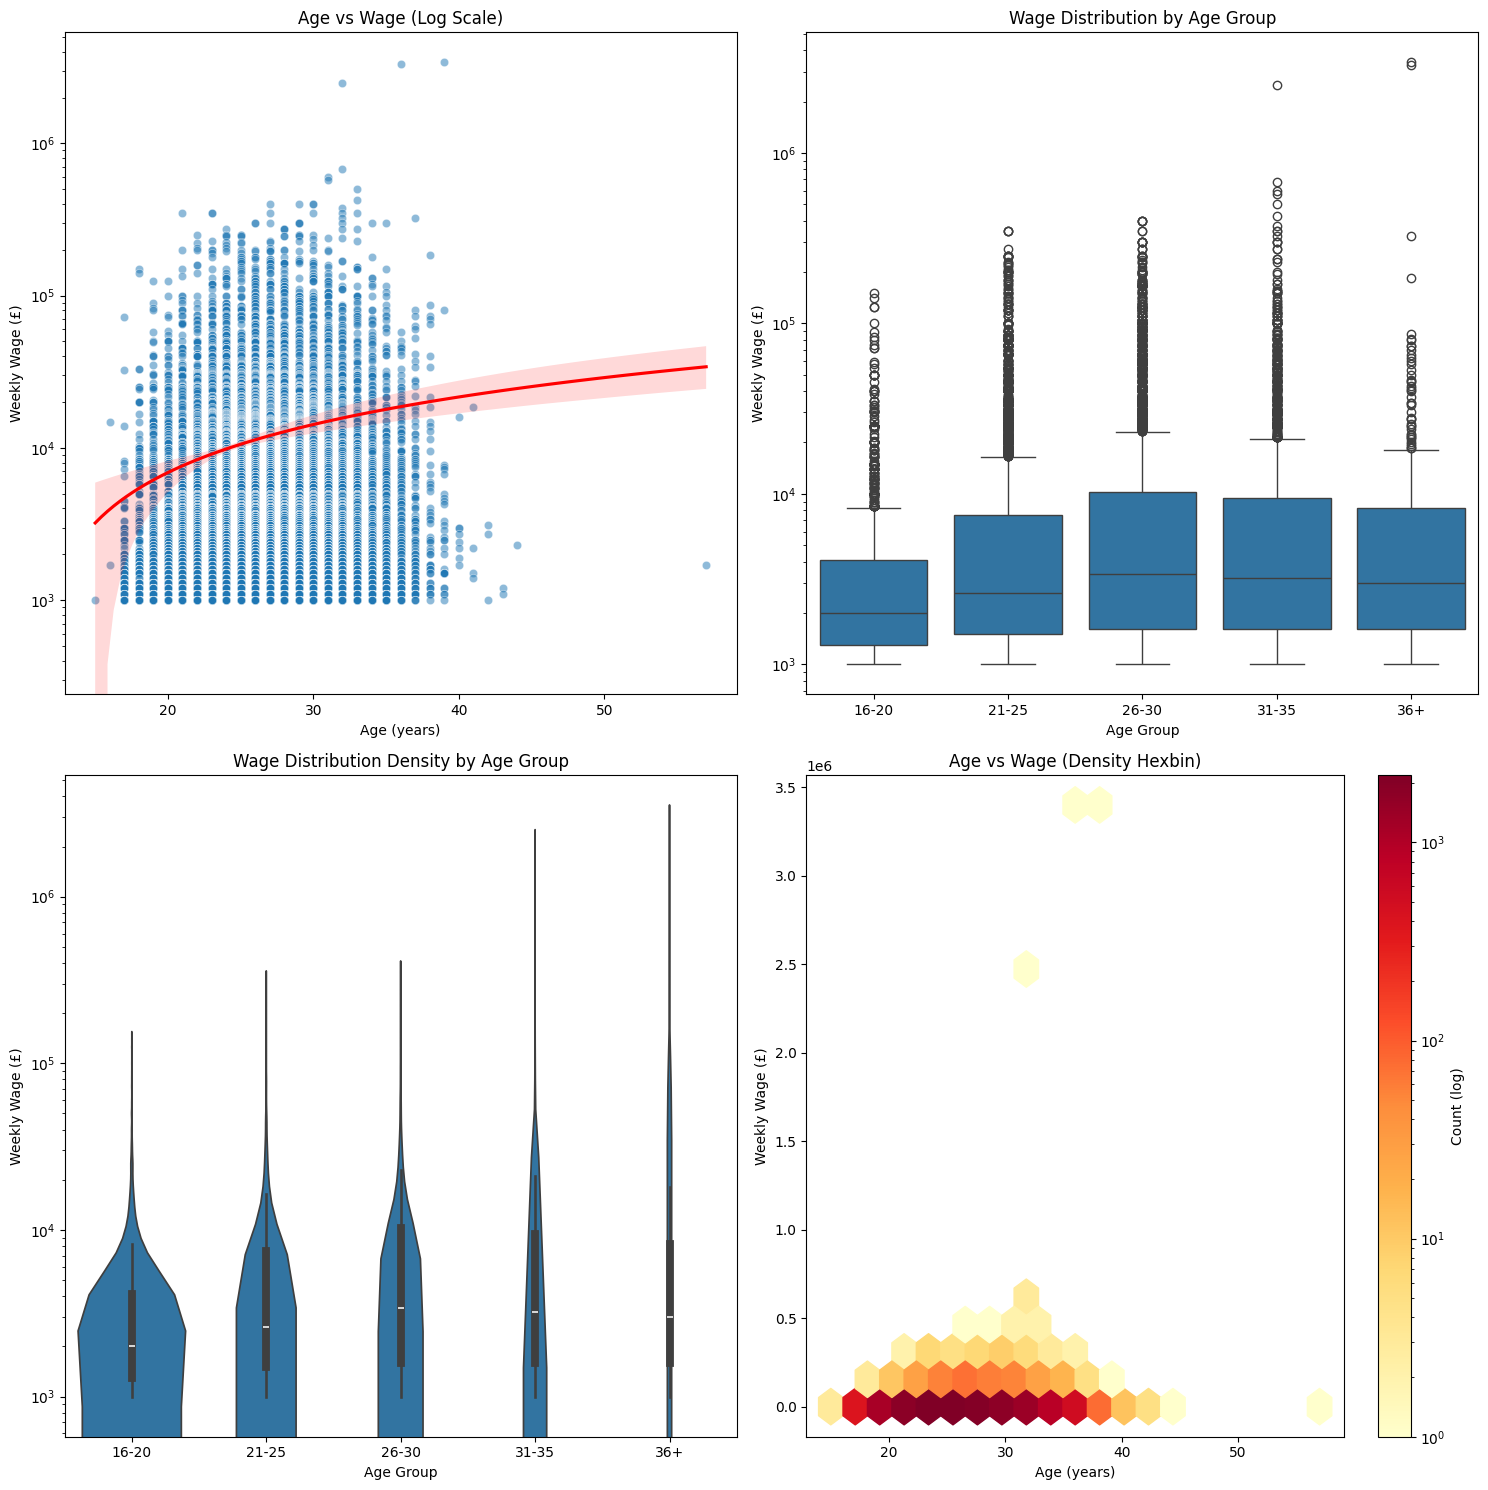

In [24]:
# Create a figure with 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# 1. Original scatter with log scale
sns.scatterplot(data=df, x='Age', y='Wage', alpha=0.5, ax=ax1)
sns.regplot(data=df, x='Age', y='Wage', scatter=False, color='red', ax=ax1)
ax1.set_yscale('log')
ax1.set_title('Age vs Wage (Log Scale)')
ax1.set_xlabel('Age (years)')
ax1.set_ylabel('Weekly Wage (£)')

# 2. Box plot by age groups
df['Age_Group'] = pd.cut(df['Age'], 
                        bins=[15, 20, 25, 30, 35, 40], 
                        labels=['16-20', '21-25', '26-30', '31-35', '36+'])
sns.boxplot(data=df, x='Age_Group', y='Wage', ax=ax2)
ax2.set_yscale('log')
ax2.set_title('Wage Distribution by Age Group')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Weekly Wage (£)')

# 3. Violin plot to show distribution
sns.violinplot(data=df, x='Age_Group', y='Wage', ax=ax3)
ax3.set_yscale('log')
ax3.set_title('Wage Distribution Density by Age Group')
ax3.set_xlabel('Age Group')
ax3.set_ylabel('Weekly Wage (£)')

# 4. Hexbin plot to show density
hb = ax4.hexbin(df['Age'], df['Wage'], 
                gridsize=20, 
                bins='log',
                cmap='YlOrRd')
ax4.set_title('Age vs Wage (Density Hexbin)')
ax4.set_xlabel('Age (years)')
ax4.set_ylabel('Weekly Wage (£)')
plt.colorbar(hb, ax=ax4, label='Count (log)')

# Adjust layout
plt.tight_layout()
plt.show()